In [1]:
#ALR - CIFAR-10 - CNN

In [2]:
import torch
import numpy as np
from torchsummary import summary
import tqdm as notebook_tqdm

/home/aaronlaszlo/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA not available. Utilizing CPU ...')
else:
    print('CUDA is available! Utilizing GPU ...')

CUDA is available! Utilizing GPU ...


In [5]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

num_workers = 16 #number of subprocesses to use for data loading (parallelization)
batch_size = 10 #sample amount
valid_size = 0.2 #percentage of training set to use as validation

In [6]:
#convert and transform data to normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [7]:
#import and select data
train_data = datasets.CIFAR10(root='data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10(root='data', train=False,
                             download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
#obtain training indices for validation
train_range = len(train_data)
indices = list(range(train_range))
np.random.shuffle(indices)
split = int(np.floor(valid_size * train_range))
train_idx, valid_idx = indices[split:], indices[split:]

In [9]:
#define samplers
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [10]:
#prepare dataloaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

In [11]:
#defining classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

def imshow(img):
    img = img / 2 + 0.5 #denormalize image
    plt.imshow(np.transpose(img, (1, 2, 0))) #convert from Tensor image    

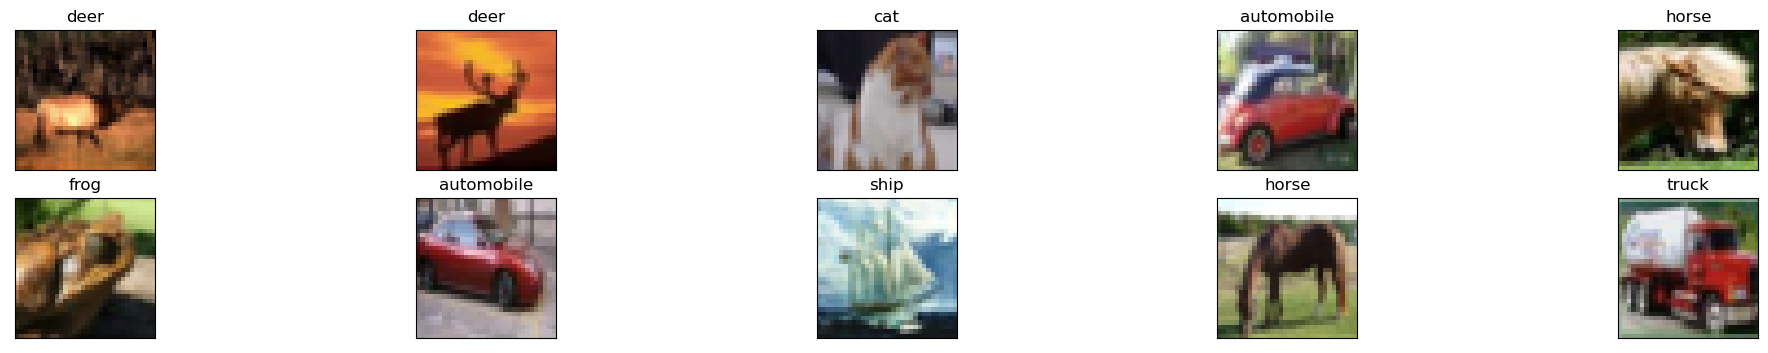

In [13]:
#obtain batch
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() #convert images to numpy for display

#plot images
fig = plt.figure(figsize=(25,4))
#display batch of num_batch
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, int(batch_size/2), idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

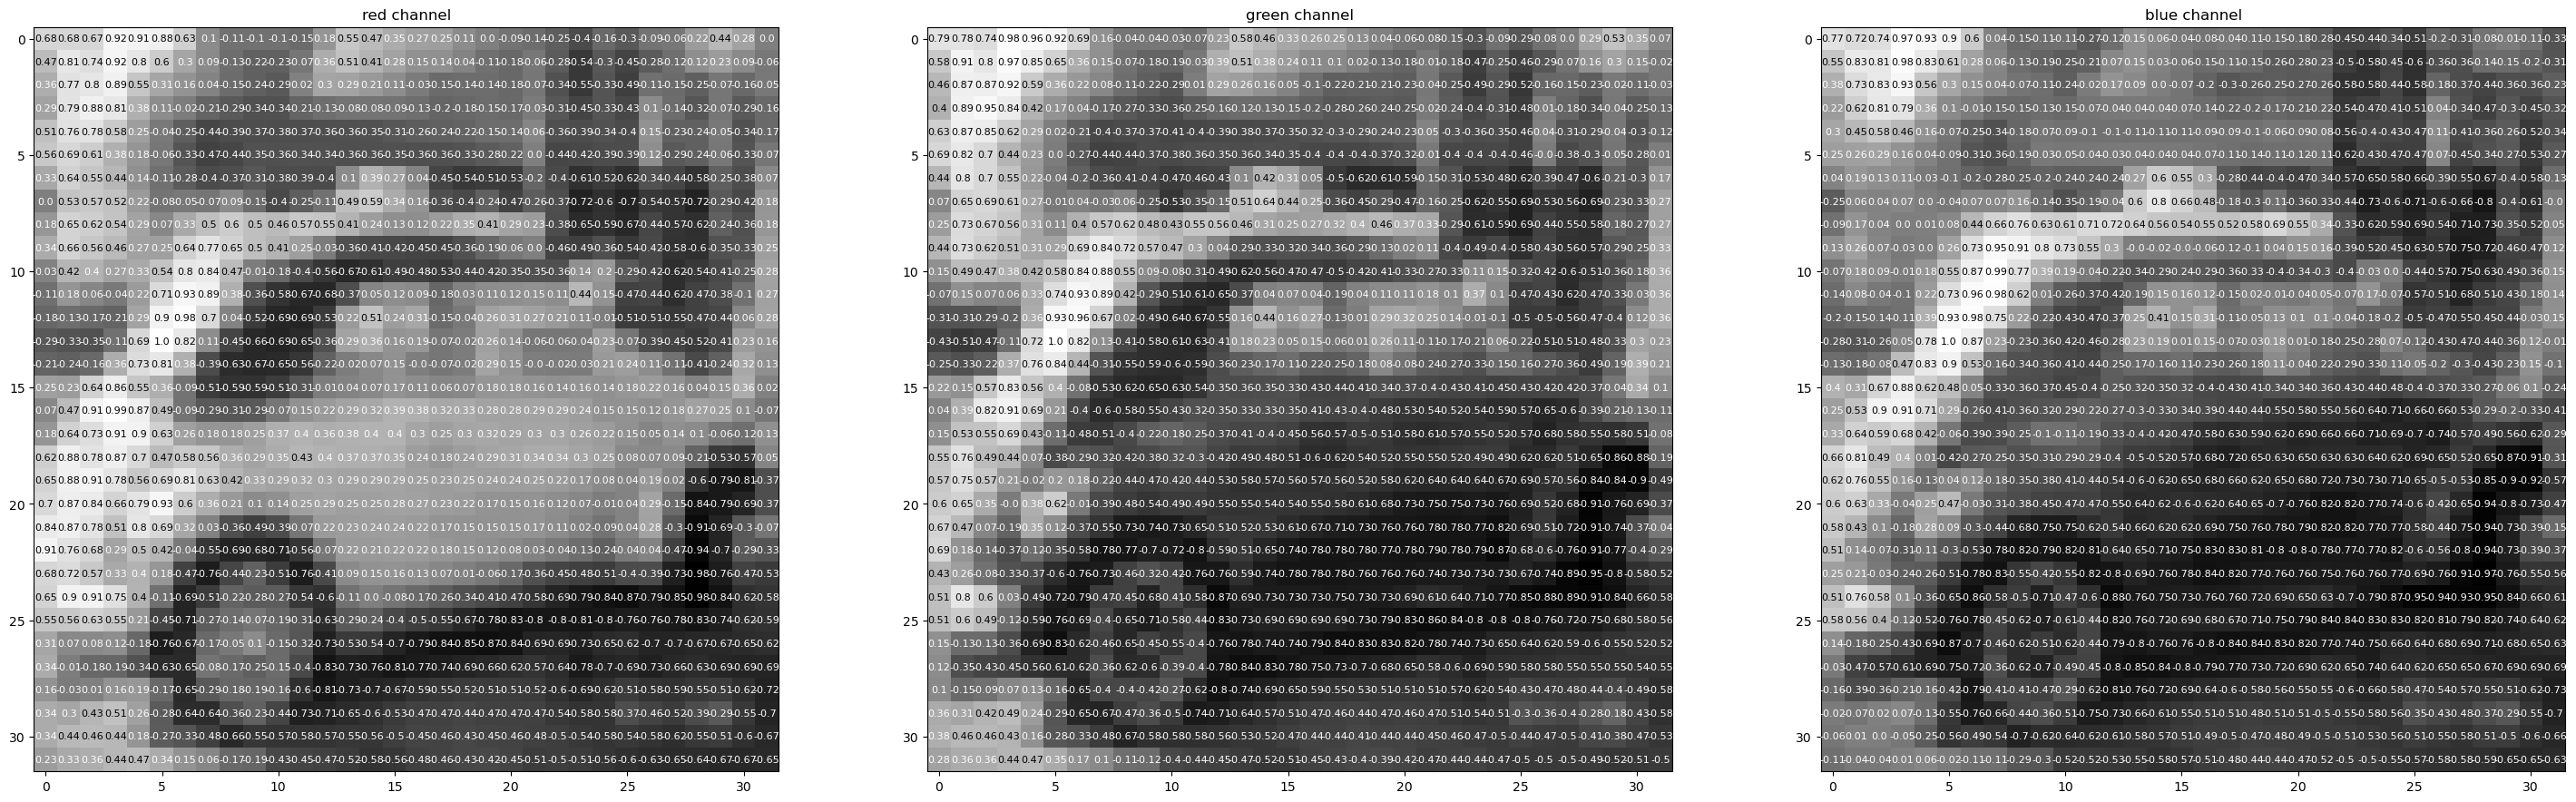

In [14]:
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

In [16]:
import torch.nn as nn
import torch.nn.functional as F

#CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  # convolutional layer (sees 32x32x3 image tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1) # convolutional layer (sees 16x16x16 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1) # convolutional layer (sees 8x8x32 tensor)
        
        self.pool = nn.MaxPool2d(2, 2)        # max pooling layer
        self.fc1 = nn.Linear(64 * 4 * 4, 500) # linear layer (64 * 4 * 4 -> 500)
        self.fc2 = nn.Linear(500, 10)         # linear layer (500 -> 10)

        self.dropout = nn.Dropout(0.25)       # dropout layer (p=0.25)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = x.view(-1, 64 * 4 * 4)  # flatten image input
        
        x = self.dropout(x)     # add dropout layer
        x = F.relu(self.fc1(x)) # add 1st hidden layer, with relu activation function
        
        x = self.dropout(x)     # add dropout layer
        x = self.fc2(x)         # add 2nd hidden layer, with relu activation function
        return x

# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

summary(model, input_size=(3, 32, 32))

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
         MaxPool2d-2           [-1, 16, 16, 16]               0
            Conv2d-3           [-1, 32, 16, 16]           4,640
         MaxPool2d-4             [-1, 32, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          18,496
         MaxPool2d-6             [-1, 64, 4, 4]              

In [17]:
import torch.optim as optim

#loss function
criterion = nn.CrossEntropyLoss()

#optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [19]:
# number of epochs to train the model
n_epochs = 5

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
   
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data.cuda())            
        loss = criterion(output.cuda(), target.cuda()) # calculate the batch loss

        loss.backward()   # backward pass: compute gradient of the loss with respect to model parameters
        optimizer.step()  # perform a single optimization step (parameter update)
        
        train_loss += loss.item()*data.size(0) # update training loss
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:

        output = model(data.cuda())                   # forward pass: compute predicted outputs by passing inputs to the model
        loss = criterion(output.cuda(), target.cuda())       # calculate the batch loss
        valid_loss += loss.item()*data.size(0) # update average validation loss 
    
    # calculate average losses
    train_loss = train_loss/ len(train_loader.sampler)
    valid_loss = valid_loss/ len(valid_loader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.960224 	Validation Loss: 0.792997
Validation loss decreased (inf --> 0.792997).  Saving model ...
Epoch: 2 	Training Loss: 0.892630 	Validation Loss: 0.742874
Validation loss decreased (0.792997 --> 0.742874).  Saving model ...
Epoch: 3 	Training Loss: 0.836391 	Validation Loss: 0.675697
Validation loss decreased (0.742874 --> 0.675697).  Saving model ...
Epoch: 4 	Training Loss: 0.776812 	Validation Loss: 0.622117
Validation loss decreased (0.675697 --> 0.622117).  Saving model ...
Epoch: 5 	Training Loss: 0.732378 	Validation Loss: 0.562290
Validation loss decreased (0.622117 --> 0.562290).  Saving model ...


In [20]:
model.load_state_dict(torch.load('model_cifar.pt'))

<All keys matched successfully>

In [21]:
#track losses
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() 
#iterate over test data
for data, target in test_loader:
    output = model(data.cuda())
    loss = criterion(output.cuda(), target.cuda())
    test_loss += loss.item()*data.size(0)
    
    _, pred = torch.max(output.cuda(), 1)
    correct_tensor = np.squeeze(pred.eq(target.data.view_as(pred).cuda()))
    
    
    # calc test accuracy for each classes
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct_tensor[i].item()
        class_total[label] += 1
        
#average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.778228

Test Accuracy of airplane: 74% (749/1000)
Test Accuracy of automobile: 88% (887/1000)
Test Accuracy of  bird: 55% (552/1000)
Test Accuracy of   cat: 48% (487/1000)
Test Accuracy of  deer: 74% (741/1000)
Test Accuracy of   dog: 60% (608/1000)
Test Accuracy of  frog: 86% (862/1000)
Test Accuracy of horse: 74% (747/1000)
Test Accuracy of  ship: 88% (883/1000)
Test Accuracy of truck: 77% (772/1000)

Test Accuracy (Overall): 72% (7288/10000)


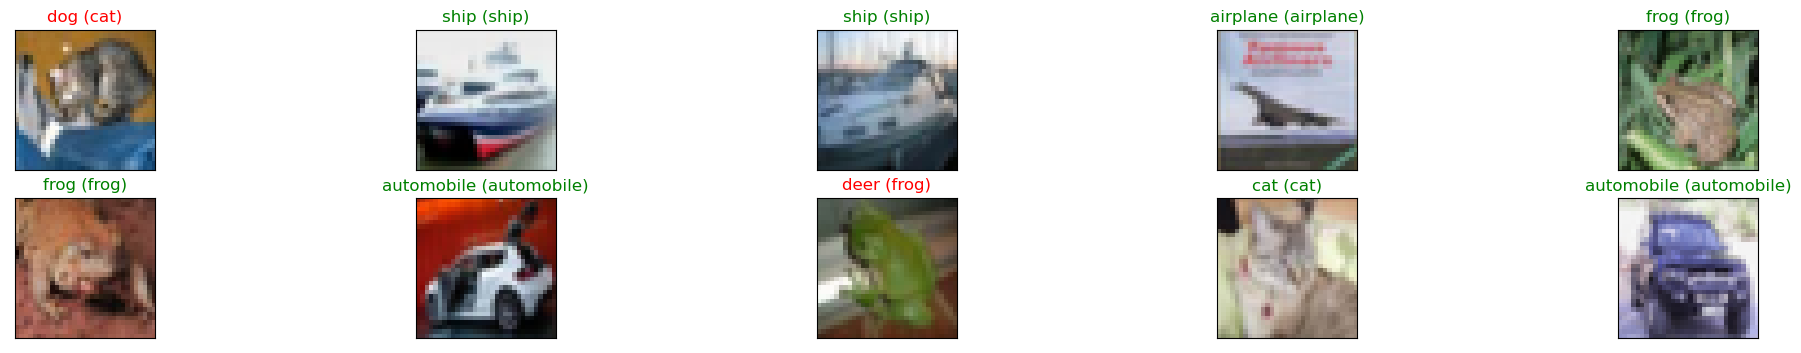

In [22]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, int(batch_size/2), idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))
